In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
import torch
import os
from scipy import stats
from scipy.stats import pearsonr
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.options.mode.chained_assignment = None 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed_list=np.load('F:/manuscript_2022_figure/model_scenario/indexwell_gridscle_without_doy/rs_info_bi.npy'
)
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)
fig_path='C:/Users/swei46.ASURITE/OneDrive/Documents/weekly_repo/manuscript_irri_timing/_figs5/'
import sys
sys.path.append('C:/Users/swei46.ASURITE/OneDrive/Documents/pydoc/classify_irrigation_py')
import classification_daily_SPINUP_Bidirection as clss

In [3]:
tensor_x_neks1=torch.load('F:/manuscript_2022_figure/hpa_0120_timing/tensor_x_neks0120_var_bi.pt')
# tensor_x_hpa=torch.load('F:/manuscript_2022_figure/tensor_x_hpa0120_var_bi.pt')

In [4]:
tensor_x_neks2=tensor_x_neks1[:,:,:-1]

In [5]:
tensor_x_neks=np.delete(tensor_x_neks2, -3, axis=-1)

In [6]:
tensor_x_neks.shape

torch.Size([20698, 154, 19])

In [7]:
para_dict = {
  "n_features": tensor_x_neks.shape[2],
  "seq_length": tensor_x_neks.shape[1],
  "hidden_size_1": 64,
  "nb_layers_1":1,
  "drop_out_1":0,
  "drop_out_2":0,
  "learning_rate":5e-5,#1e-4,
    "train_episodes":800,
    "batch_size":64,
    "random_seed":0}

In [8]:
m= torch.nn.Softmax(dim=2)

In [9]:
out_f_array=[]
for rs_ind in range(len(random_seed_list)):#
    model_load =clss.MV_LSTM(para_dict['n_features'],para_dict['seq_length'], para_dict['hidden_size_1'], 
                    para_dict['nb_layers_1'], para_dict['drop_out_1'],para_dict['drop_out_2'])
    model_load_path='F:/manuscript_2022_figure/model_scenario/indexwell_gridscle_without_doy/model'+str(rs_ind)+'.pt'
    model_load.load_state_dict(torch.load(model_load_path))
    model_load.to(device)
    model_int=model_load.eval()
    output_ksne1 =m( model_int(tensor_x_neks[0:5000,:,:].to(device))).cpu().data.numpy()
    output_ksne2 =m( model_int(tensor_x_neks[5000:10000,:,:].to(device))).cpu().data.numpy()
    output_ksne3 =m( model_int(tensor_x_neks[10000:15000,:,:].to(device))).cpu().data.numpy()
    output_ksne4 = m(model_int(tensor_x_neks[15000:,:,:].to(device))).cpu().data.numpy()

    output_neks_full= np.concatenate([output_ksne1, output_ksne2, output_ksne3,output_ksne4], axis=0)
    out_f_array.append(output_neks_full)

# let's vote

In [10]:
fin_out=np.array(out_f_array)
fin_out_label=np.argmax(fin_out, axis=3) # soft max to find the label

In [11]:
fin_out_label.shape, fin_out.shape

((20, 20698, 154), (20, 20698, 154, 2))

In [12]:
from scipy import stats as st
out_hpa_array_vote,_=st.mode(fin_out_label, axis=0)  # 20 runs vote the label

In [13]:
out_hpa_fin=np.squeeze(out_hpa_array_vote, axis=0)

In [14]:
out_hpa_fin.shape

(20698, 154)

In [15]:
# let's read the information data
# it is NEKS grid label and years from 2001-2020
hpa_info=pd.read_csv('F:/manuscript_2022_figure/hpa_0120_timing/neks_tensor_x_0120_INFO_var_bi.csv', index_col=0)


In [16]:
# match the lstm result with grid info
hap_fin_0120=pd.DataFrame(data=out_hpa_fin, index=hpa_info.index)
hap_fin_0120['year']=hpa_info['year']


In [17]:
# hap_fin_0120.to_csv('F:/manuscript_2022_figure/hpa_0120_timing/neks_0120_timing_vote.csv')
# hap_fin_0120=pd.read_csv('F:/manuscript_2022_figure/hpa_0120_timing/neks_0120_timing_vote.csv')

In [18]:
out_hpa_array_sum=np.sum(hap_fin_0120.iloc[:,17:-15], axis=1)

In [19]:
hpa_info['annual_irri_day']=out_hpa_array_sum

# or we can also find the mean interannual total irrigation days

In [20]:
hpa_info[hpa_info['annual_irri_day']==0]=np.nan# find the annual total irrigation days (jjas)

In [21]:

hpa_annual=hpa_info.groupby(hpa_info.index).size() #
indexl2=hpa_annual[hpa_annual>1].index

In [22]:
aaa=hpa_info[hpa_info.index.isin(indexl2)]

In [23]:
hpa_info_average_year=aaa.groupby(aaa.index).mean() 

In [24]:
aaaaa=hpa_info[hpa_info['annual_irri_day']<10]

In [25]:
aaaaa.groupby(aaaaa.year).size()

year
2001.0     1
2003.0     3
2004.0    15
2005.0     6
2006.0     3
2007.0     4
2008.0    13
2009.0    11
2010.0     4
2011.0     2
2013.0     1
2014.0     6
2015.0     3
2016.0    15
2017.0     1
2018.0     3
2019.0    14
dtype: int64

hpa_info_average_year

# Intermonth plot for KS and NE

# Scatter plot of annual irri VS pr and tem

In [27]:
fold_pth='D:/HPA/HPA_schedule/01-22_ts/ready_X/'
ne_ks=pd.read_csv('D:\HPA\HPA_schedule\hpa_ne_ks_grid.csv')
grid_ne_ks=ne_ks[ne_ks.Intersect!=0]['label']

In [28]:
pr=pd.read_csv(fold_pth+'pr.csv')
pr.index=pd.to_datetime(pr['time'])
pr_gs=pr[pr.index.month.isin([6, 7,8,9])]
pr_anual_gs=pr_gs.groupby(pr_gs.index.year).sum()
ne_ks_filter=[int(i) in grid_ne_ks.tolist() for i in pr_anual_gs.columns]
pr_anual_gs_neks=pr_anual_gs.iloc[:,ne_ks_filter]

In [29]:
agl=pd.read_csv(fold_pth+'agri_area.csv')
agl.index=pd.to_datetime(agl['time'])
agl_gs=agl[agl.index.month.isin([6, 7,8,9])]
agl_anual_gs=agl_gs.groupby(agl_gs.index.year).mean()
agl_anual_gs_neks=agl_anual_gs.iloc[:,ne_ks_filter]
df_agl =agl_anual_gs_neks.stack().reset_index().astype(float)


In [30]:
irrl=pd.read_csv(fold_pth+'irri_area.csv')
irrl.index=pd.to_datetime(irrl['time'])
irrl_gs=irrl[irrl.index.month.isin([6, 7,8,9])]
irrl_anual_gs=irrl_gs.groupby(irrl_gs.index.year).mean()
irrl_anual_gs_neks=irrl_anual_gs.iloc[:,ne_ks_filter]
df_irrl =irrl_anual_gs_neks.stack().reset_index().astype(float)

In [31]:
tem=pd.read_csv(fold_pth+'tem.csv')
tem.index=pd.to_datetime(tem['time'])
tem_gs=tem[tem.index.month.isin([6, 7,8,9])]
tem_anual_gs=tem_gs.groupby(tem_gs.index.year).mean()
tem_anual_gs_neks=tem_anual_gs.iloc[:,ne_ks_filter].fillna(99999)
df_tem =tem_anual_gs_neks.stack().reset_index().astype(float)


In [32]:
vpd=pd.read_csv(fold_pth+'vpd.csv')
vpd.index=pd.to_datetime(vpd['time'])
vpd_gs=vpd[vpd.index.month.isin([6, 7,8,9])]
vpd_anual_gs=vpd_gs.groupby(vpd_gs.index.year).mean()
vpd_anual_gs_neks=vpd_anual_gs.iloc[:,ne_ks_filter].fillna(99999)
df_vpd=vpd_anual_gs_neks.stack().reset_index().astype(float)

In [33]:
df = pr_anual_gs_neks.stack().reset_index().astype(float)
df.columns = ['year','grid','pr']
df['tem']=df_tem.iloc[:,-1]
df['vpd']=df_vpd.iloc[:,-1]
df['agl']=df_agl.iloc[:,-1]
df['irrl']=df_irrl.iloc[:,-1]

In [34]:
hpa_info = hpa_info.reset_index()

In [35]:
a= [True if ((df['grid'][i] in hpa_info['grid'].tolist()) & (df['year'][i] in hpa_info['year'])) else False for i in range (len(df)) ]

In [36]:
df_tmp=df[a]

In [37]:
df_con=df_tmp.drop(df_tmp[df_tmp['tem'] > 100].index)

In [38]:
df_con

year     grid          pr        tem       vpd       agl      irrl
3      2001.0   3218.0  165.162621  29.164299  1.612091  0.435926  0.017640
6      2001.0   3221.0  157.541945  30.322690  1.710004  0.101201  0.019507
7      2001.0   3222.0  165.809705  30.823218  1.750269  0.490610  0.473145
8      2001.0   3223.0  163.062541  30.655763  1.719026  0.374747  0.412423
9      2001.0   3224.0  157.470085  30.368493  1.679216  0.164447  0.194467
...       ...      ...         ...        ...       ...       ...       ...
42125  2022.0  10049.0  188.309029  30.966051  1.596837       NaN       NaN
42126  2022.0  10050.0  157.675474  31.001539  1.631702       NaN       NaN
42127  2022.0  10051.0  132.295314  31.093973  1.655721       NaN       NaN
42128  2022.0  10161.0  188.676108  30.837790  1.571075       NaN       NaN
42129  2022.0  10162.0  176.996764  30.717753  1.568001       NaN       NaN

[28453 rows x 7 columns]

In [39]:
merged_df = pd.merge(hpa_info, df_con, on=['grid','year'], how='inner')

In [40]:
merged_df_ks=merged_df[merged_df.state=='KS']
merged_df_ne=merged_df[merged_df.state=='NE']

In [41]:
index_result=pd.read_csv('F:/manuscript_2022_figure/hpa_0120_timing/index_well_results_same_para.csv', index_col=0)


In [42]:
index_result

pr_sum   tem_mean  vpd_mean  total_d  year well_no
0    302.681644  27.612962  1.084564     38.0  2008    NE_4
1    320.828829  26.061600  0.932285     25.0  2009    NE_4
2    407.325193  28.710364  1.154321     41.0  2010    NE_4
3    318.784973  31.131867  1.663177     42.0  2011    NE_4
4    116.080818  33.073595  2.362045     56.0  2012    NE_4
..          ...        ...       ...      ...   ...     ...
129  250.432077  32.579064  1.696158     83.0  2015   KS_26
130  472.819230  31.348491  1.485953     84.0  2016   KS_26
131  173.377537  30.880037  1.610917     70.0  2017   KS_26
132  400.010924  30.758224  1.412586     90.0  2018   KS_26
133  350.858846  31.757811  1.413545     43.0  2019   KS_26

[134 rows x 6 columns]

In [43]:

test_result=index_result
ne_ind=["NE" in na for na in test_result['well_no']]
ks_ind=["KS" in na for na in test_result['well_no']]

In [44]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)

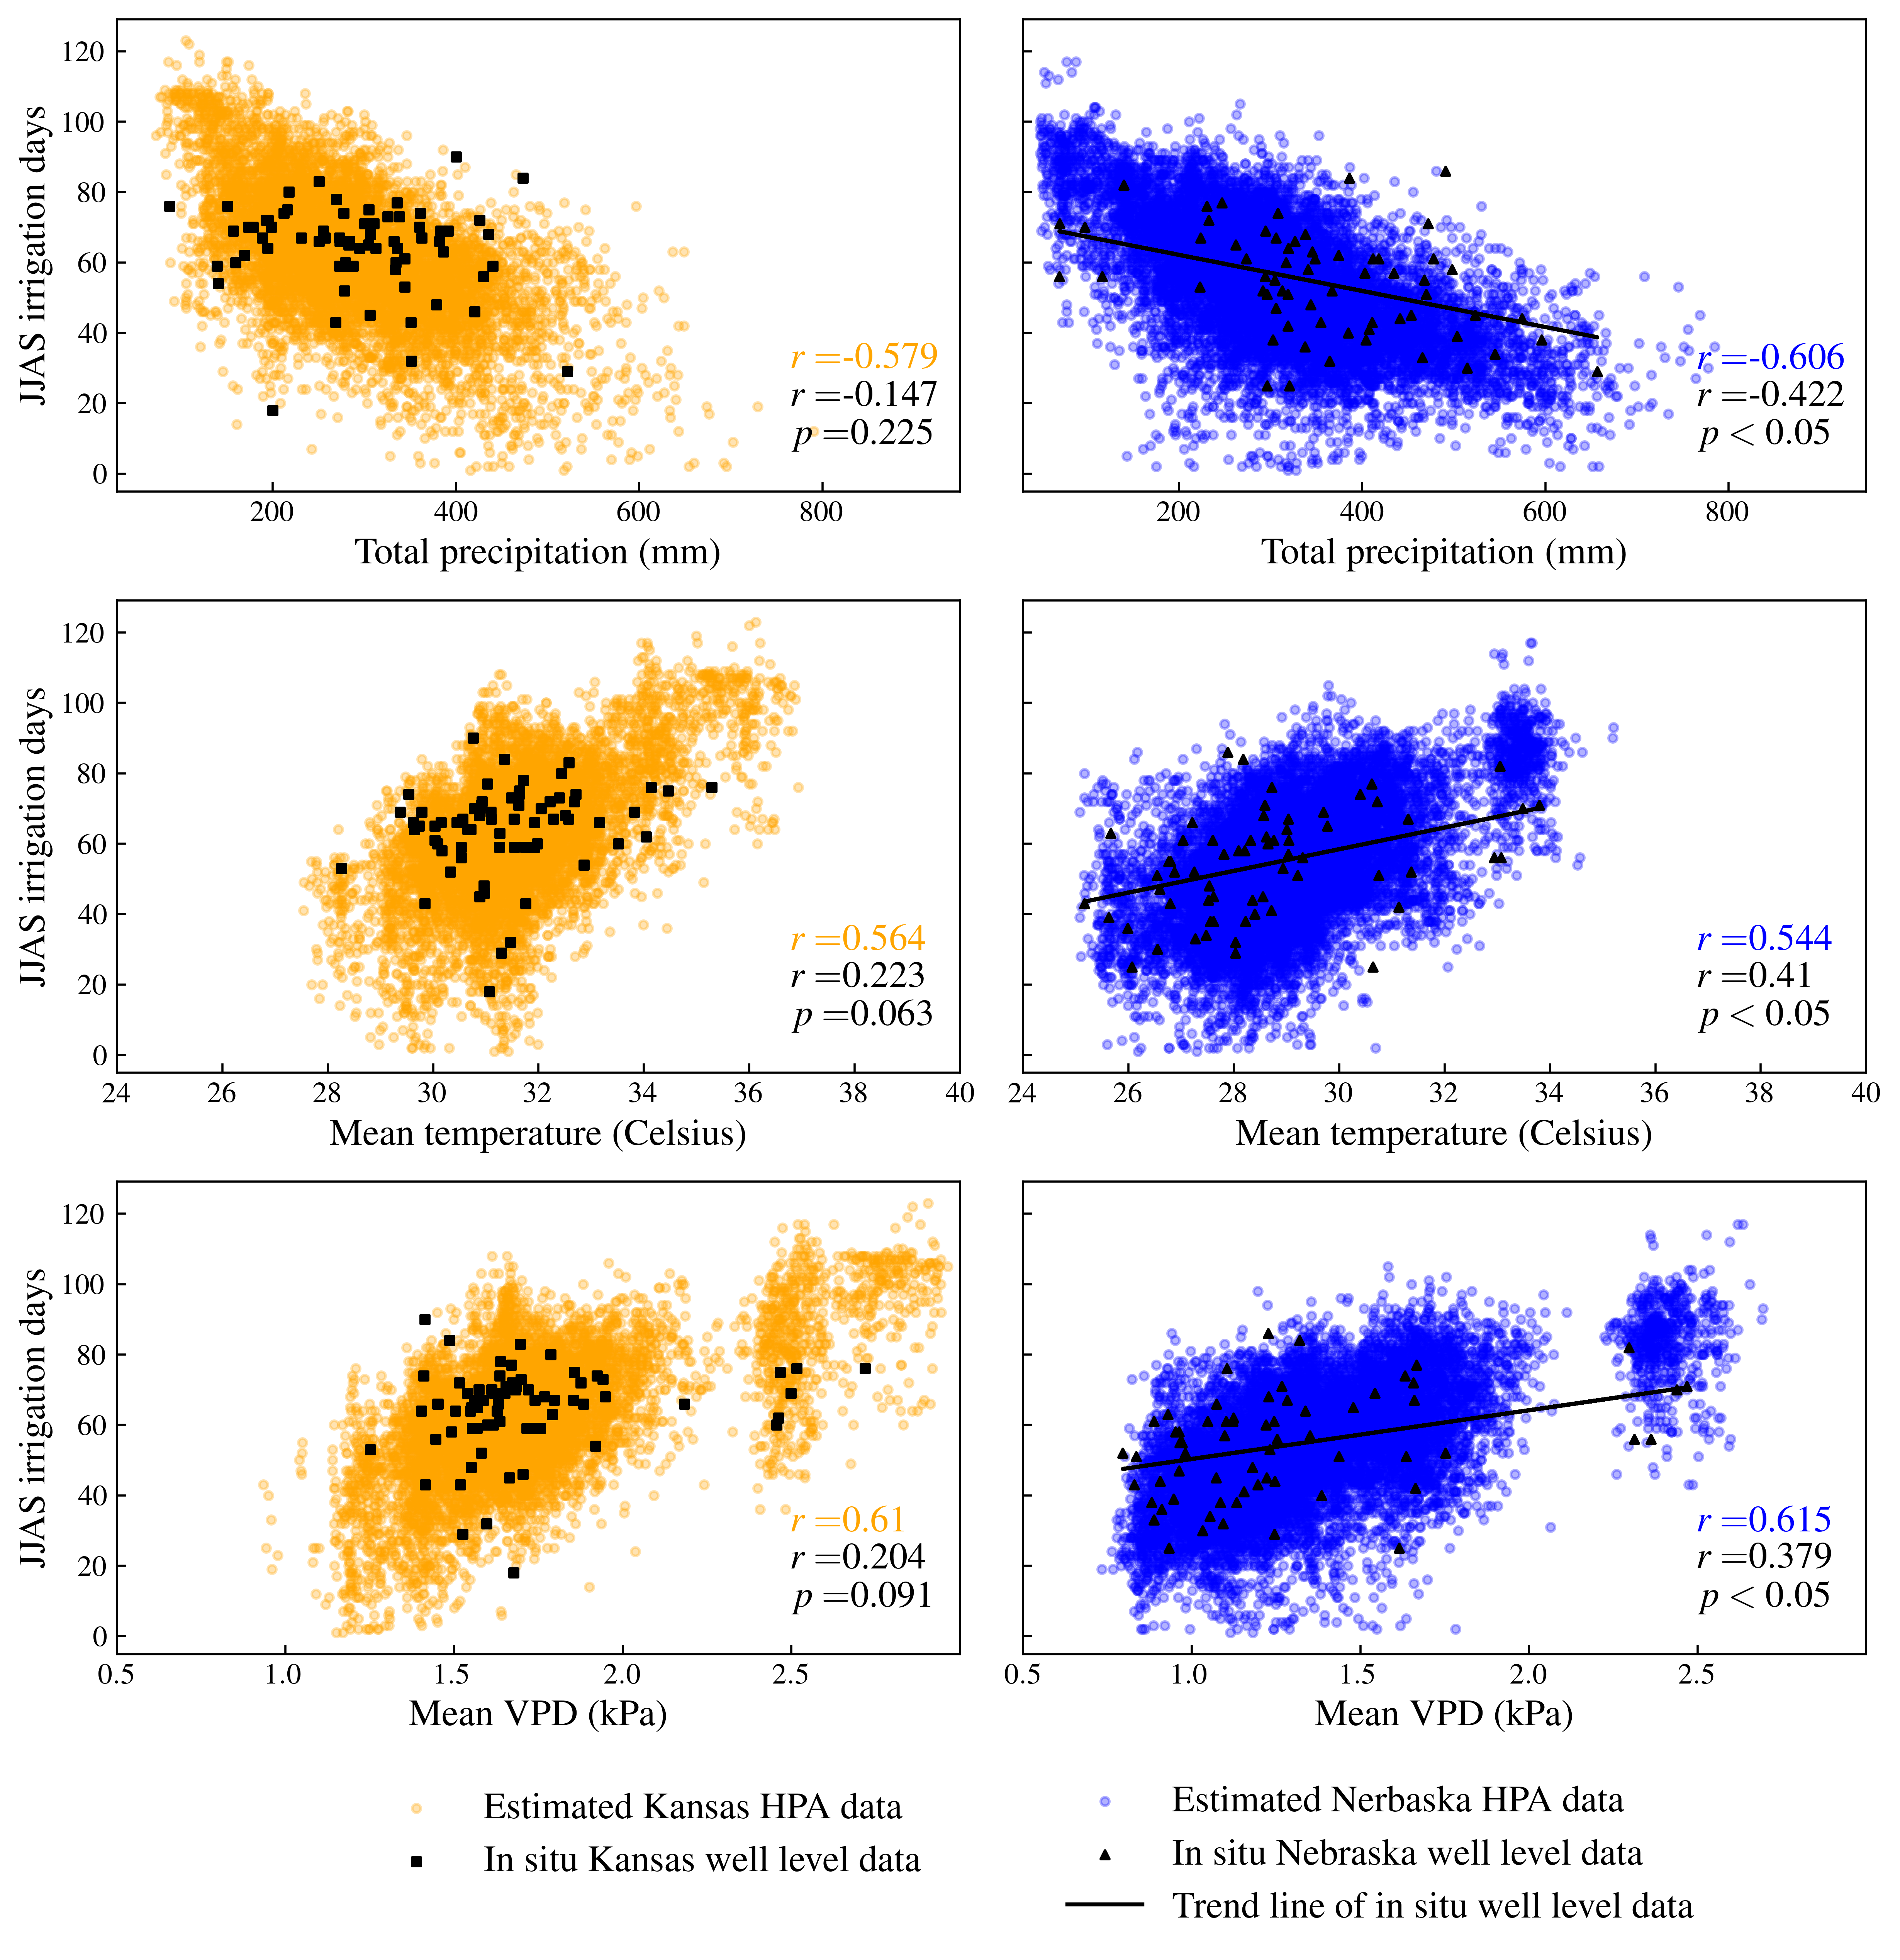

In [70]:



space=0.1
txt_size=14
label_size=11
fig,axes=plt.subplots(nrows=4, ncols=2,sharey=True,figsize=(10,12),dpi=500)
ax=axes.flatten()

parameters=['pr_sum','pr_sum','tem_mean','tem_mean','vpd_mean','vpd_mean']
parameters2=['pr','pr','tem','tem','vpd','vpd']
xlabel=['Total precipitation (mm)','Total precipitation (mm)','Mean temperature (Celsius)'
        ,'Mean temperature (Celsius)','Mean VPD (kPa)','Mean VPD (kPa)'
       ]

for axa in (1,3,5): 
    ax[axa].scatter(merged_df_ne[parameters2[axa]], merged_df_ne['annual_irri_day'],color='blue', label='Estimated Nerbaska HPA data', marker='o', s=10, alpha=0.3)
    cv_ne,_=pearsonr(merged_df_ne[parameters2[axa]], merged_df_ne['annual_irri_day'])
    ax[axa].text(0.8, 0.26, '$r=$' +str(round(cv_ne,3)),  transform=ax[axa].transAxes,color="blue", fontsize=txt_size)
    
    ax[axa].tick_params(direction='in',labelsize=label_size)
    ax[axa].scatter(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'],color='k', marker='^'
                    , s=10, label='In situ Nebraska well level data')
    pr_ne = np.polyfit(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'], 1)
    fit_pr_ne = np.poly1d(pr_ne)
    r_r,_=pearsonr(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'])
    ax[axa].plot(test_result[ne_ind][parameters[axa]], fit_pr_ne(test_result[ne_ind][parameters[axa]]), "k-"
            ,label='Trend line of in situ well level data')#  , dashes=(1, 20)   
    ax[axa].set_xlabel(xlabel[axa], fontsize=txt_size)
    _, _, _, p_ne, _ = stats.linregress(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'])

    ax[axa].text(0.8, 0.1, '$r=$' +str(round(r_r,3))+'\n'+'$p<0.05$',  transform=ax[axa].transAxes,color="k", fontsize=txt_size)

    
for axa in (0,2,4):  
    
    ax[axa].scatter(merged_df_ks[parameters2[axa]], merged_df_ks['annual_irri_day'],color='orange', label='Estimated Kansas HPA data', marker='o', s=10, alpha=0.3)
    cv_ks,_=pearsonr(merged_df_ks[parameters2[axa]], merged_df_ks['annual_irri_day'])
    ax[axa].text(0.8, 0.26, '$r=$' +str(round(cv_ks,3)),  transform=ax[axa].transAxes,color="orange", fontsize=txt_size)
    ax[axa].tick_params(direction='in',labelsize=label_size)
    pr_ks = np.polyfit(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'], 1)
    fit_pr_ks = np.poly1d(pr_ks)
    r_ks,_=pearsonr(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'])
    # ax[axa].plot(test_result[ks_ind][parameters[axa]], fit_pr_ks(test_result[ks_ind][parameters[axa]]), "orange",
    #      linestyle='--'     , dashes=(1, 5)   )#
    ax[axa].scatter(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'],color='k', marker='s', s=10, label='In situ Kansas well level data')
   
    ax[axa].set_xlabel(xlabel[axa], fontsize=txt_size)
    ax[axa].set_ylabel(' JJAS irrigation days', fontsize=txt_size)
    _, _, _, p_ks, _ = stats.linregress(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'])

    
    ax[axa].text(0.8, 0.1, '$r=$' +str(round(r_ks,3))+'\n'+'$p=$'+str(round(p_ks,3)),  transform=ax[axa].transAxes,color="k", fontsize=txt_size)
# '$p=$'+str(round(p_ks,3))
ax[0].set_xlim([30,950])
ax[1].set_xlim([30,950])
ax[2].set_xlim([24,40])
ax[3].set_xlim([24,40])


ax[4].set_xticks(np.linspace(0,2.5,6))
ax[5].set_xticks(np.linspace(0,2.5,6))

ax[4].set_xlim([0.5,3])
ax[5].set_xlim([0.5,3])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right',bbox_to_anchor=(0.5, 0.17),fontsize=txt_size, frameon=False)
handles1, labels1 = ax[1].get_legend_handles_labels()
fig.legend(handles1, labels1, loc='lower right',bbox_to_anchor=(0.9, 0.15),fontsize=txt_size, frameon=False)

# ax[0].legend()#bbox_to_anchor=(1.2, 0.9))
# ax[1].legend()#bbox_to_anchor=(1.2, 0.9))
# ax[2].legend()
# ax[3].legend()
fig.tight_layout() 
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
# fig.savefig(fig_path+'prVSdays_pergrid_NEvs_ks.tif',bbox_inches='tight',dpi=500)    
plt.show()

In [ ]:
hpa_info_average_year[hpa_info_average_year.index==8041]

In [ ]:
hpa_info_average_year[hpa_info_average_year.annual_irri_day >100]

In [ ]:
merged_df

# agl, IL, grid, index plot

In [ ]:
agl_well=pd.read_csv('D:/NE_TX_KS_time_series/x_01-20_original/agri_area.csv')
agl_well.index=pd.to_datetime(agl_well['time'])
agl_well_gs=agl_well[agl_well.index.month.isin([6,7,8,9])]
agl_well_anual_gs=agl_well_gs.groupby(agl_well_gs.index.year).mean()
agl_well_fin=agl_well_anual_gs[list(set(index_result['well_no']))]#.fillna(99999)
df_agl_well=agl_well_fin.stack().reset_index()#.astype(float)
df_agl_well.columns=['year','well_no','agri']
merged_index = pd.merge(index_result, df_agl_well, on=['year','well_no'], how='inner')

In [ ]:
irrl_well=pd.read_csv('D:/NE_TX_KS_time_series/x_01-20_original/denisarea.csv')
irrl_well.index=pd.to_datetime(irrl_well['time'])
irrl_well_gs=irrl_well[irrl_well.index.month.isin([6,7,8,9])]
irrl_well_anual_gs=irrl_well_gs.groupby(irrl_well_gs.index.year).mean()
irrl_well_fin=irrl_well_anual_gs[list(set(index_result['well_no']))]#.fillna(99999)
df_irrl_well=irrl_well_fin.stack().reset_index()#.astype(float)
df_irrl_well.columns=['year','well_no','irri']


In [ ]:
merged_index_fin = pd.merge(merged_index, df_irrl_well, on=['year','well_no'], how='inner')

In [ ]:
test_result=merged_index_fin.drop(merged_index_fin [merged_index_fin ['agri']<-1].index)

In [ ]:
test_result['irri'].where(test_result['irri'] <1, 1, inplace=True)

In [ ]:
test_result[test_result['irri']==0]

In [ ]:
ne_ind=["NE" in na for na in test_result['well_no']]
ks_ind=["KS" in na for na in test_result['well_no']]

In [ ]:
test_result[ks_ind]['total_d'].mean()

In [ ]:
test_result[ne_ind]['total_d'].mean()

In [ ]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)

In [ ]:
txt_size=10
label_size=8
fig,ax=plt.subplots(nrows=1, ncols=1,sharey=True,figsize=(6,6),dpi=200)

ax.scatter(test_result[ne_ind]['irri'],test_result[ne_ind]['total_d'],color='k', marker='^', s=10, label='In situ Nebraska well level data')
pr_ne = np.polyfit(test_result[ne_ind]['irri'],test_result[ne_ind]['total_d'], 1)
fit_pr_ne = np.poly1d(pr_ne)
r_r,_=pearsonr(test_result[ne_ind]['irri'],test_result[ne_ind]['total_d'])
ax.plot(test_result[ne_ind]['irri'], fit_pr_ne(test_result[ne_ind]['irri']), "k-",label='Trend line of in situ well level data')
ax.text(0.75, 0.85, '$r=$' +str(round(r_r,3)),  transform=ax.transAxes,color="k", fontsize=txt_size)
ax.set_xlabel('Irrigated area', fontsize=txt_size)

ax.scatter(test_result[ks_ind]['irri'],test_result[ks_ind]['total_d'],color='b', marker='s', s=10, label='In situ Kansas well level data')
pr_ks = np.polyfit(test_result[ks_ind]['irri'],test_result[ks_ind]['total_d'], 1)
fit_pr_ks = np.poly1d(pr_ks)
r_ks,_=pearsonr(test_result[ks_ind]['irri'],test_result[ks_ind]['total_d'])
ax.plot(test_result[ks_ind]['irri'], fit_pr_ks(test_result[ks_ind]['irri']), "b-")
ax.text(0.75, 0.95, '$r=$' +str(round(r_ks,3)),  transform=ax.transAxes,color="b", fontsize=txt_size)

ax.legend()

In [ ]:



space=0.1
txt_size=10
label_size=8
fig,axes=plt.subplots(nrows=3, ncols=2,sharey=True,figsize=(6,8),dpi=200)
ax=axes.flatten()

parameters=['agri','agri','irri','irri']
parameters2=['agl','agl','irrl','irrl']
xlabel=[
       'Agricultural land percentage','Agricultural land percentage'
        ,'Irrigated land percentage','Irrigated land percentage'
       ]

for axa in (1,3): 
    ax[axa].scatter(merged_df_ne[parameters2[axa]], merged_df_ne['annual_irri_day'],color='blue'
                    , label='Estimated Nerbaska HPA data', marker='o', s=3, alpha=0.15)
    cv_ne,_=pearsonr(merged_df_ne[parameters2[axa]], merged_df_ne['annual_irri_day'])
    ax[axa].text(0.75, 0.75, '$r=$' +str(round(cv_ne,3)),  transform=ax[axa].transAxes,color="blue", fontsize=txt_size)
    
    ax[axa].tick_params(direction='in',labelsize=label_size)
    ax[axa].scatter(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'],color='k', marker='^', s=10, label='In situ Nebraska well level data')
    pr_ne = np.polyfit(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'], 1)
    fit_pr_ne = np.poly1d(pr_ne)
    r_r,_=pearsonr(test_result[ne_ind][parameters[axa]],test_result[ne_ind]['total_d'])
    ax[axa].plot(test_result[ne_ind][parameters[axa]], fit_pr_ne(test_result[ne_ind][parameters[axa]]), "k-",label='Trend line of in situ well level data')
    ax[axa].text(0.75, 0.85, '$r=$' +str(round(r_r,3)),  transform=ax[axa].transAxes,color="k", fontsize=txt_size)
    ax[axa].set_xlabel(xlabel[axa], fontsize=txt_size)
    
    
    
for axa in (0,2):  
    
    ax[axa].scatter(merged_df_ks[parameters2[axa]], merged_df_ks['annual_irri_day'],color='orange', label='Estimated Kansas HPA data', marker='o', s=3, alpha=0.3)
    cv_ks,_=pearsonr(merged_df_ks[parameters2[axa]], merged_df_ks['annual_irri_day'])
    ax[axa].text(0.75, 0.75, '$r=$' +str(round(cv_ks,3)),  transform=ax[axa].transAxes,color="orange", fontsize=txt_size)
    ax[axa].tick_params(direction='in',labelsize=label_size)

    ax[axa].scatter(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'],color='k', marker='s', s=10, label='In situ Kansas well level data')
    pr_ks = np.polyfit(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'], 1)
    fit_pr_ks = np.poly1d(pr_ks)
    r_ks,_=pearsonr(test_result[ks_ind][parameters[axa]],test_result[ks_ind]['total_d'])
    ax[axa].plot(test_result[ks_ind][parameters[axa]], fit_pr_ks(test_result[ks_ind][parameters[axa]]), "k-")
    ax[axa].text(0.75, 0.85, '$r=$' +str(round(r_ks,3)),  transform=ax[axa].transAxes,color="k", fontsize=txt_size)
    ax[axa].set_xlabel(xlabel[axa], fontsize=txt_size)
    ax[axa].set_ylabel(' Annual irrigation days', fontsize=txt_size)
    ### ax[0].sharex(ax[2])

ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,1])
ax[3].set_xlim([0,1])


# ax[4].set_xticks(np.linspace(0,2.5,6))
# ax[5].set_xticks(np.linspace(0,2.5,6))

# ax[4].set_xlim([0.5,3])
# ax[5].set_xlim([0.5,3])

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right',bbox_to_anchor=(0.5, 0.17),fontsize=txt_size, frameon=False)
handles1, labels1 = ax[1].get_legend_handles_labels()
fig.legend(handles1, labels1, loc='lower right',bbox_to_anchor=(0.9, 0.15),fontsize=txt_size, frameon=False)

# ax[0].legend()#bbox_to_anchor=(1.2, 0.9))
# ax[1].legend()#bbox_to_anchor=(1.2, 0.9))
# ax[2].legend()
# ax[3].legend()
fig.tight_layout() 
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])
# fig.savefig(fig_path+'prVSdays_pergrid_NEvs_ks.tif',bbox_inches='tight',dpi=500)    
plt.show()

## Interannual irrigation across state for NE and KS

In [ ]:

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)

In [ ]:
fit_interannual_ne,fit_interannual_ks

In [ ]:
kkk.loc['KS']['annual_irri_day']

In [ ]:
kkk=merged_df.groupby(['state','year']).mean()
space=0.1
txt_size=14
label_size=10
fig,axes=plt.subplots(nrows=1, ncols=1,figsize=(9,3),dpi=200)
space=0.1
year=list(range(2001,2021))
ax2=axes.twinx()
axes.plot(year,kkk.loc['KS']['annual_irri_day'],'-o', markersize=5,label='Kansas HPA',color='orange')
axes.plot(year,kkk.loc['NE']['annual_irri_day'],'-s', markersize=5,label='Nebraska HPA',color='b')

# interannual_ne = np.polyfit(year,kkk.loc['NE']['annual_irri_day'], 1)
# fit_interannual_ne = np.poly1d(interannual_ne)
# _, _, _, p_interannual_ne, _ = stats.linregress(year,kkk.loc['NE']['annual_irri_day'])
# axes.plot(year, fit_interannual_ne(year), '--',color='b')
# axes.text(0.35, 0.25, '$p=$' +str(round(p_interannual_ne,3)),  transform=axes.transAxes,color="b", fontsize=txt_size)

# interannual_ks = np.polyfit(year,kkk.loc['KS']['annual_irri_day'], 1)
# fit_interannual_ks = np.poly1d(interannual_ks)
# _, _, _, p_interannual_ks, _ = stats.linregress(year,kkk.loc['KS']['annual_irri_day'])
# axes.plot(year, fit_interannual_ks(year),'--',color='orange')
# axes.text(0.35, 0.7, '$p=$' +str(round(p_interannual_ks,3)),  transform=axes.transAxes,color="orange", fontsize=txt_size)

axes.set_ylim([0,100])




axes.tick_params(direction='in',labelsize=label_size)
axes.set_xticks(year)
axes.tick_params(axis='both', direction='in') 
axes.tick_params(direction='in',labelsize=label_size)

ax2.bar(np.array(year)-space, kkk.loc['KS']['pr'], 0.2, label='Precipitation of Kansas HPA',color='orange',alpha=0.3)
ax2.bar(np.array(year)+space, kkk.loc['NE']['pr'], 0.2, label='Precipitation of Nebraska HPA',color='b',alpha=0.3)
ax2.invert_yaxis()
ax2.tick_params(direction='in',labelsize=label_size)
axes.legend(fontsize=label_size, loc='lower left',bbox_to_anchor=(0.00, 0.17), frameon=False )
ax2.legend(fontsize=label_size, frameon=False)
axes.set_xlabel('Year')
axes.set_ylabel('JJAS irrigation days')
ax2.set_ylabel('Total precipitation (mm)')
plt.show()
fig.savefig(fig_path+'ks_ne_anual_time_series.tif',bbox_inches='tight',dpi=500)    


In [ ]:
kkk.loc['KS']['annual_irri_day'].mean(), kkk.loc['NE']['annual_irri_day'].mean()

In [ ]:
kkk.loc['KS']['annual_irri_day'].std(), kkk.loc['NE']['annual_irri_day'].std()

# let's plot

In [76]:
import geopandas as gpd
import pyproj

from matplotlib.ticker import EngFormatter
# Plot the polygon as a basemap

formatter0 = EngFormatter(unit=chr(176))

df_neks=gpd.read_file("D:/shapefile/Nebraska_Kansas/Nebraska_Kansas.shp")

df_hpa=gpd.read_file("D:/shapefile/hpa_ne_ks/hpa_neks.shp")
df_river=gpd.read_file("D:/shapefile/hpa_river_ne_ks/hpa_river_neks_clip.shp")
# Define the projected coordinate system (replace with your projection)
crs_proj = pyproj.CRS.from_epsg(32618)

# Define the geographic coordinate system (replace with your desired GCS)
crs_latlon = pyproj.CRS.from_epsg(4326)

# Define a transformer to convert from projected to geographic coordinates
transformer = pyproj.Transformer.from_crs(crs_proj, crs_latlon, always_xy=True)


polygon_neks = df_neks['geometry']
polygon_hpa = df_hpa['geometry']
polygon_river = df_river['geometry']

# Convert the polygon to a WKT string

polygon_gdf_neks = gpd.GeoDataFrame(geometry=polygon_neks)
polygon_gdf_hpa = gpd.GeoDataFrame(geometry=polygon_hpa)
polygon_gdf_river = gpd.GeoDataFrame(geometry=polygon_river)

# Convert the polygon coordinates to geographic coordinates
polygon_neks_plt = polygon_gdf_neks.to_crs(crs_latlon)
polygon_hpa_plt = polygon_gdf_hpa.to_crs(crs_latlon)
polygon_river_plt = polygon_gdf_river.to_crs(crs_latlon)

In [79]:
hpa_info[

year state  annual_irri_day
grid                                
3218   2001.0    NE             83.0
3222   2001.0    NE             63.0
3223   2001.0    NE             82.0
3334   2001.0    NE             73.0
3335   2001.0    NE             60.0
...       ...   ...              ...
10049  2020.0    NE             77.0
10050  2020.0    NE             62.0
10051  2020.0    NE             65.0
10161  2020.0    NE             65.0
10162  2020.0    NE             64.0

[20698 rows x 3 columns]

In [91]:
# hpa_info.index=hpa_info['grid']
hpa_single_ye=hpa_info[hpa_info['year']==2012]
# hpa_single_ye.index=hpa_single_ye['grid']

year               2004.000
annual_irri_day      15.000
longitude          -103.999
latitude             37.000
dtype: float64

In [107]:
import shapely.wkt
geo_poly=pd.read_csv('F:/noah_grid_jason.csv') #load hpd grid geometry file
geo_poly.index=geo_poly['label']
geo_hpa=geo_poly.loc[geo_poly.index. isin(hpa_info_average_year.index)]# find the NE KS grid  hpa_single_ye hpa_info_average_year

In [108]:
# prepare the lon and lat of NE KS grid
polygon_tobbox=[np.unique(np.round(shapely.wkt.loads(g).exterior.xy, 4)).flatten() for g in geo_hpa['geometry']]
polygon_center=[[(g[2]+ g[3])/2, (g[1]+ g[0])/2 ] for g in polygon_tobbox]
poly_center_array=np.array(polygon_center)

In [109]:
hpa_info_average_year['longitude']=poly_center_array[:,1]
hpa_info_average_year['latitude']=poly_center_array[:,0]

In [ ]:
poly_center_array

In [ ]:
# set lon and la to datafram
hpa_single_ye['longitude']=poly_center_array[:,1]
hpa_single_ye['latitude']=poly_center_array[:,0]

In [99]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
# rc.rcParams['font.size'] = 12
rc('text', usetex=True)

In [113]:
hpa_info_average_year[hpa_info_average_year['latitude']<40]['annual_irri_day'].mean()

61.03302799956935

In [114]:
hpa_info_average_year[hpa_info_average_year['latitude']>40]['annual_irri_day'].mean()

53.60740967934216

In [ ]:
txt_size=10
label_size=8
fig,axes=plt.subplots(nrows=2, ncols=1, sharex='all',figsize=(3,3),dpi=200)


ne_annual_ave=hpa_info_average_year[hpa_info_average_year['latitude']>=40]['annual_irri_day']
ks_annual_ave=hpa_info_average_year[hpa_info_average_year['latitude']<40]['annual_irri_day']

# hist_ne, bins_ne = np.histogram(ne_annual_ave, bins=20)
# bin_centers = (bins_ne[1:]+bins_ne[:-1])*0.5
# axes[0].plot(bin_centers, hist_ne)

axes[0].hist(ne_annual_ave,bins=20)
axes[0].set_ylabel('Frequence', fontsize=txt_size)

axes[0].tick_params(direction='in',labelsize=label_size)
axes[1].tick_params(direction='in',labelsize=label_size)
axes[1].set_ylim([0,120])
axes[0].set_ylim([0,120])
axes[1].hist(ks_annual_ave,bins=20)

# hist_ks, bins_ks = np.histogram(ks_annual_ave, bins=20)
# bin_centers = (bins_ks[1:]+bins_ks[:-1])*0.5
# axes[1].plot(bin_centers, hist_ks)

axes[1].set_ylabel('Frequence', fontsize=txt_size)
axes[0].text(0.95, 0.8,'Skewness: ' +str(round(skew(ne_annual_ave),2))
          , transform=axes[0].transAxes, fontsize=txt_size, va='bottom', ha='right')
axes[1].text(0.95, 0.8,'Skewness: ' +str(round(skew(ks_annual_ave),2))
          , transform=axes[1].transAxes, fontsize=txt_size, va='bottom', ha='right')


fig.tight_layout() 

axes[1].set_xlabel('JJAS irrigation days', fontsize=txt_size)

In [ ]:
a[0]

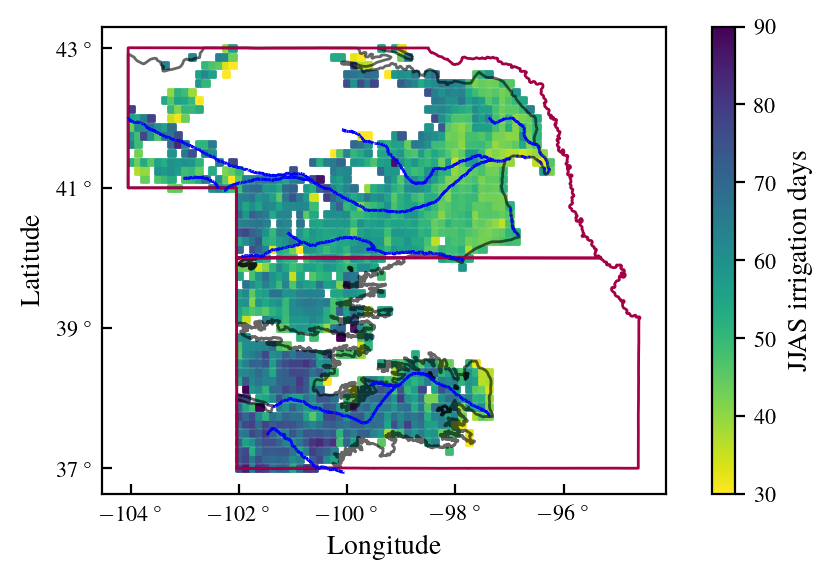

In [115]:
txt_size=10
label_size=8

fig,axes=plt.subplots(nrows=1, ncols=1, sharex='all',figsize=(5,3),dpi=200)
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()
p1=axes.scatter(hpa_info_average_year['longitude'],hpa_info_average_year['latitude'],marker='s',s=5,c=hpa_info_average_year['annual_irri_day'], cmap=reversed_map,vmin=30, vmax=90)
axes = polygon_hpa_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='k',alpha=0.6, facecolor='none')
axes = polygon_neks_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='#A30046', facecolor='none')
axes = polygon_river_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='blue', facecolor='none')

axes.tick_params(direction='in', labelsize=label_size)
axes.set_xticks(np.arange(-104, -94, step=2))
axes.set_yticks(np.arange(37, 44, step=2))

cbar=fig.colorbar(p1,  ax=axes,orientation='vertical')
axes.set_xlabel('Longitude', fontsize=txt_size)
axes.set_ylabel('Latitude', fontsize=txt_size)
axes.xaxis.set_major_formatter(formatter0)
axes.yaxis.set_major_formatter(formatter0)


cbar.set_label('JJAS irrigation days', fontsize=txt_size)
cbar.ax.tick_params(labelsize=label_size)
fig.tight_layout() 
fig.savefig(fig_path+'hpa_spatialplot_20yearAVE.tif',bbox_inches='tight',dpi=500)    

# plt.show()

In [ ]:

txt_size=10
label_size=8
fig,axes=plt.subplots(nrows=1, ncols=1, sharex='all',figsize=(5,3),dpi=200)
orig_map=plt.cm.get_cmap('viridis')
reversed_map = orig_map.reversed()
p1=axes.scatter(hpa_single_ye['longitude'],hpa_single_ye['latitude'],marker='s',s=5,c=hpa_single_ye['annual_irri_day'], cmap=reversed_map,vmin=20, vmax=100)
axes = polygon_hpa_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='k',alpha=0.6, facecolor='none')
axes = polygon_neks_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='#A30046', facecolor='none')

axes = polygon_river_plt.plot(ax=axes, figsize=(5,3),linewidth=1, edgecolor='blue', facecolor='none')

axes.tick_params(direction='in', labelsize=label_size)
axes.set_xticks(np.arange(-104, -94, step=2))
axes.set_yticks(np.arange(37, 44, step=2))

cbar=fig.colorbar(p1,  ax=axes,orientation='vertical')
axes.set_xlabel('Longitude', fontsize=txt_size)
axes.set_ylabel('Latitude', fontsize=txt_size)
axes.xaxis.set_major_formatter(formatter0)
axes.yaxis.set_major_formatter(formatter0)


cbar.set_label('JJAS irrigation days', fontsize=txt_size)
cbar.ax.tick_params(labelsize=label_size)
fig.savefig(fig_path+'hpa_spatialplot_2012.tif',bbox_inches='tight',dpi=500)    
fig.tight_layout() 
# plt.show()